In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [8]:
# Define the KNN class
class KNN:
    def __init__(self, k=3, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric

    def fit(self, X, y):
        # TODO: Implement the fit method
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        

    def predict(self, X):
        # TODO: Implement the predict method
        y_pred = []
        for x_test in X:
        # Compute distances between x_test and all training data
            distances = self.compute_distance(self.X_train, x_test)
        # Get indices of k nearest neighbors
            k_indices = np.argsort(distances)[:self.k]
        # Get the labels of the k nearest neighbors
            k_nearest_labels = self.y_train[k_indices]
        # Majority vote to decide the class
            unique, counts = np.unique(k_nearest_labels, return_counts=True)
            y_pred.append(unique[np.argmax(counts)])
        return np.array(y_pred)

    def compute_distance(self, X1, X2):
        # TODO: Implement distance computation based on self.distance_metric
        # Hint: Use numpy operations for efficient computation
        if self.distance_metric == 'euclidean':
            return np.sqrt(np.sum((X1 - X2) ** 2, axis=1))
        elif self.distance_metric == 'manhattan':
            return np.sum(np.abs(X1 - X2), axis=1)


In [9]:
def remove_outliers_iqr(df, columns):
    """
    Remove outliers from specified columns using the IQR method.
    Outliers are defined as values outside 1.5*IQR from Q1 and Q3.
    
    :param df: DataFrame from which to remove outliers.
    :param columns: List of columns to check for outliers.
    :return: DataFrame with outliers removed.
    """
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1

    # Filter out rows that are outliers
    return df[~((df[columns] < (Q1 - 1.5 * IQR)) | (df[columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [10]:
def preprocess_data(train_path, test_path):
    # Load the data
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    
    #remove outliers
    #train_data = remove_outliers_iqr(train_data, ['Balance', 'EstimatedSalary', 'Age', 'NumOfProducts'])
    
    # Separate target and features
    X_train = train_data[['Age', 'NumOfProducts', 'Balance', 'IsActiveMember', 'HasCrCard']]  # Only the selected features
    y_train = train_data['Exited']

    X_test = test_data[['Age', 'NumOfProducts', 'Balance', 'IsActiveMember', 'HasCrCard']]

    # Define numeric and categorical features
    numeric_features = ['Age', 'NumOfProducts', 'Balance']
    categorical_features = ['IsActiveMember', 'HasCrCard']

    # Preprocessing pipeline for numerical features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
        ('scaler', StandardScaler())  # Standardize features
    ])

    # Preprocessing pipeline for categorical features
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent value
        ('onehot', OneHotEncoder(drop='if_binary'))  # One-hot encode binary categories
    ])

    # Combine both numerical and categorical transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Apply transformations to both training and test data
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    return X_train, y_train, X_test

In [13]:
# Define cross-validation function
def cross_validate(X, y, knn, n_splits=5):
    # Ensure y is a NumPy array for slicing
    y = np.array(y)  # Add this line to convert y into a NumPy array

    # Cross-validation with StratifiedKFold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_val)
        
        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)
    
    return auc_scores

In [14]:
# Load and preprocess data
X, y, X_test = preprocess_data('/Users/sophie/Desktop/CS506/assignment-5/cs-506-predicting-customer-churn-using-knn/train.csv', '/Users/sophie/Desktop/CS506/assignment-5/cs-506-predicting-customer-churn-using-knn/test.csv')


# Create and evaluate model
knn = KNN(k=5, distance_metric='euclidean')

# Perform cross-validation
cv_scores = cross_validate(X, y, knn)

print("Cross-validation scores:", cv_scores)

/Users/sophie/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


Cross-validation scores: [0.772730092558128, 0.7622232148026833, 0.7967575665157368, 0.7859889256900446, 0.7717887358171932]


In [15]:
best_k = None
best_distance_metric = None
best_auc = -1

for k in range(1,20):  # Trying k values from 1 to 20
    for distance_metric in ['euclidean', 'manhattan']:
        knn = KNN(k=k, distance_metric=distance_metric)
        cv_scores = cross_validate(X, y, knn)
        mean_auc = np.mean(cv_scores)
        print(f"k: {k}, distance_metric: {distance_metric}, AUC: {mean_auc}")
        if mean_auc > best_auc:
            best_auc = mean_auc
            best_k = k
            best_distance_metric = distance_metric

print(f"Best k: {best_k}, Best distance_metric: {best_distance_metric}, Best AUC: {best_auc}")


k: 1, distance_metric: euclidean, AUC: 0.7492721025508251
k: 1, distance_metric: manhattan, AUC: 0.7477876242365953
k: 2, distance_metric: euclidean, AUC: 0.7192253270742524
k: 2, distance_metric: manhattan, AUC: 0.7176331984039491
k: 3, distance_metric: euclidean, AUC: 0.7724949506881003
k: 3, distance_metric: manhattan, AUC: 0.7760533506108483
k: 4, distance_metric: euclidean, AUC: 0.7465495116883564
k: 4, distance_metric: manhattan, AUC: 0.7513793157239036
k: 5, distance_metric: euclidean, AUC: 0.7778977070767572
k: 5, distance_metric: manhattan, AUC: 0.7797068741978697
k: 6, distance_metric: euclidean, AUC: 0.7622357343934831
k: 6, distance_metric: manhattan, AUC: 0.7603150170391677
k: 7, distance_metric: euclidean, AUC: 0.784231200688662
k: 7, distance_metric: manhattan, AUC: 0.7864159293750967
k: 8, distance_metric: euclidean, AUC: 0.7679678027508807
k: 8, distance_metric: manhattan, AUC: 0.7677663779744307
k: 9, distance_metric: euclidean, AUC: 0.7859583447800755
k: 9, distance_

In [16]:
# TODO: Train on full dataset with optimal hyperparameters and make predictions on test set
knn = KNN(k=best_k, distance_metric=best_distance_metric)
knn.fit(X, y)
test_predictions = knn.predict(X_test)

In [18]:
# Save test predictions
pd.DataFrame({'id': pd.read_csv('/Users/sophie/Desktop/CS506/assignment-5/cs-506-predicting-customer-churn-using-knn/test.csv')['id'], 'Exited': test_predictions}).to_csv('/Users/sophie/Desktop/CS506/assignment-5/submissions-5.csv', index=False)

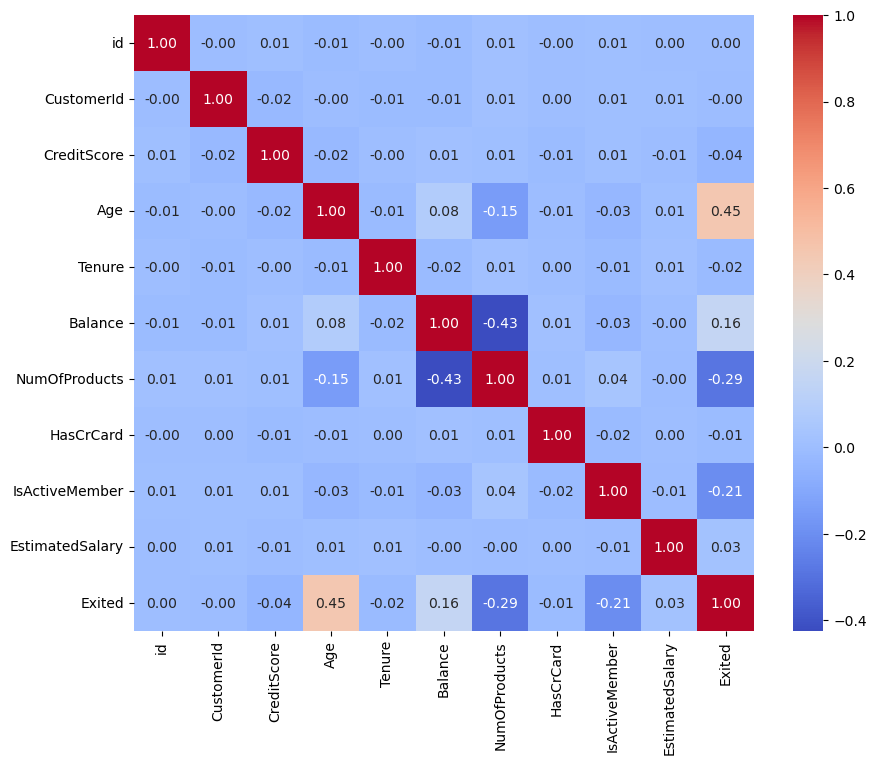

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

def correlation_matrix(data):
    corr = data.corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.show()

# Example usage with training data (including target 'Exited')
train_data = pd.read_csv('/Users/sophie/Desktop/CS506/assignment-5/cs-506-predicting-customer-churn-using-knn/train.csv')
correlation_matrix(train_data)